In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from gensim.models import Word2Vec


In [2]:
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.width', 50) 

## ISOT DATABASE

In [3]:
fake_df = pd.read_csv("/Users/bianp/Desktop/FakeNewsDetection/Fake.csv")
real_df = pd.read_csv("/Users/bianp/Desktop/FakeNewsDetection/True.csv")

## Data Analysis 

Comparison of subject and date of publication 

In [4]:
fake_df['label'] = 0  # We label fake news as 0df_fake
real_df['label'] = 1  # We label real news as 1

In [5]:
df = pd.concat([fake_df, real_df], ignore_index=True)

In [6]:
# Check for missing data
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [7]:
# Check for balance proportion of fake vs real news 
print("\nClass distribution: 0 for fake, 1 for real ")
print(df['label'].value_counts())


Class distribution: 0 for fake, 1 for real 
label
0    23481
1    21417
Name: count, dtype: int64


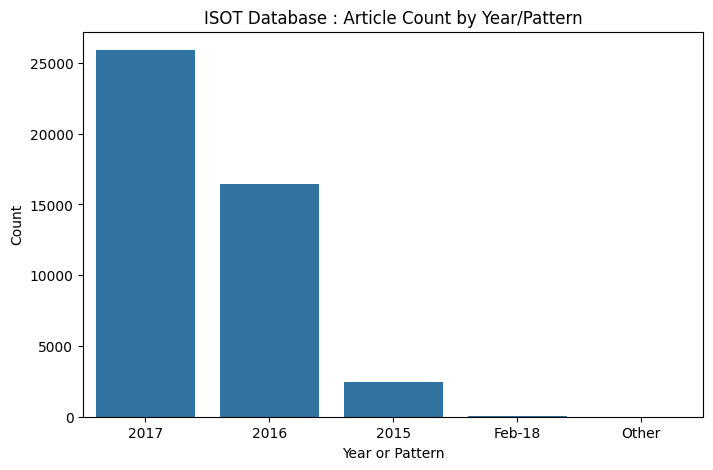

In [23]:
# Make sure 'date' is string type
df['date'] = df['date'].astype(str)

# Define patterns to search for
patterns = ['2014', '2015', '2016', '2017', 'Feb-18']

# Initialize empty list to store matched year/pattern
year_list = []

for date in df['date']:
    matched = False
    for pattern in patterns:
        if pattern in date:
            year_list.append(pattern)
            matched = True
            break  # stop after first match
    if not matched:
        year_list.append('Other')

# Add extracted year/pattern to DataFrame
df['year_extracted'] = year_list

# Calculate value counts
year_counts = df['year_extracted'].value_counts()

# Plot the counts
plt.figure(figsize=(8,5))
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.title('ISOT Database : Article Count by Year/Pattern')
plt.xlabel('Year or Pattern')
plt.ylabel('Count')
plt.show()


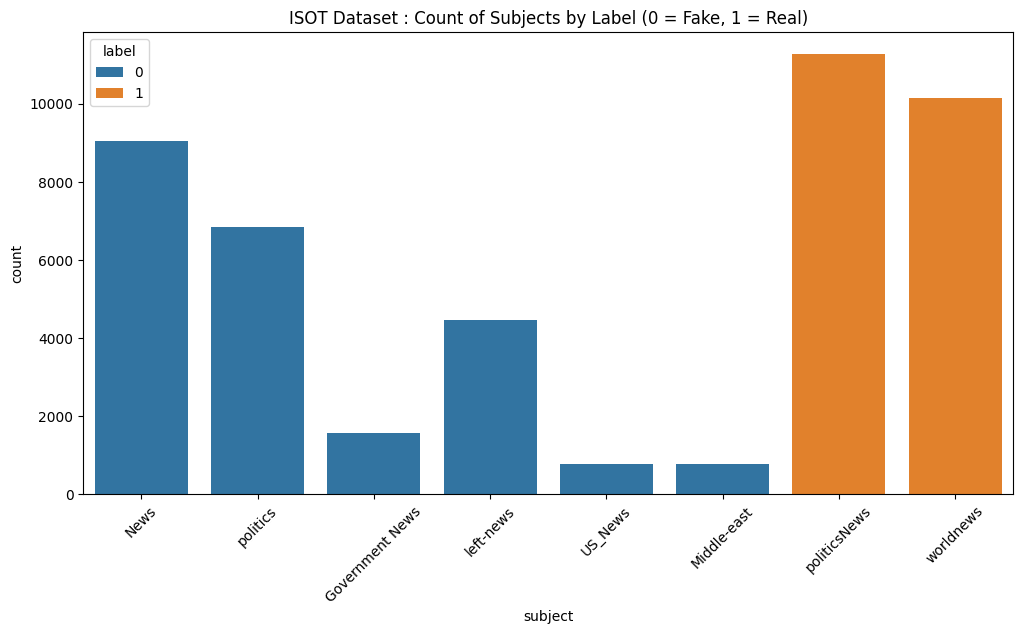

In [24]:
# Plot subject counts by label
plt.figure(figsize=(12,6))
sns.countplot(x='subject', hue='label', data=df)
plt.title('ISOT Dataset : Count of Subjects by Label (0 = Fake, 1 = Real)')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Calculate mean length of article per label
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
mean_lengths = df.groupby('label')['text_length'].mean()
print("\nMean article length per label:")
print(mean_lengths)


Mean article length per label:
label
0    423.197905
1    385.640099
Name: text_length, dtype: float64


In [11]:
# Calculate mean length of article per label
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))
mean_lengths = df.groupby('label')['title_length'].mean()
print("\nMean title length per label:")
print(mean_lengths)


Mean title length per label:
label
0    14.732805
1     9.954475
Name: title_length, dtype: float64


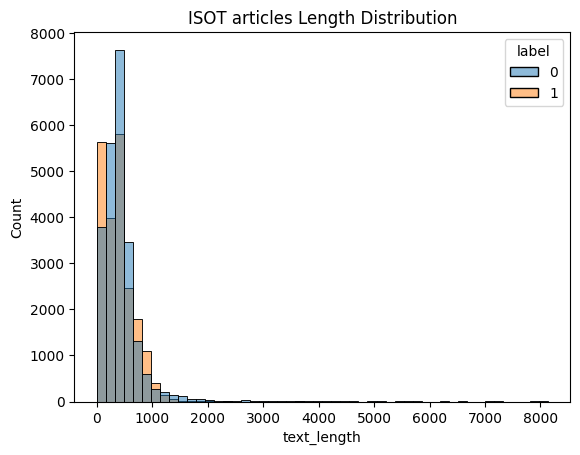

In [ ]:
# Text length analysis

sns.histplot(data=df, x='text_length', hue='label', bins=50)
plt.title('ISOT articles Length Distribution 0=Fake , 1=Real')
plt.show()

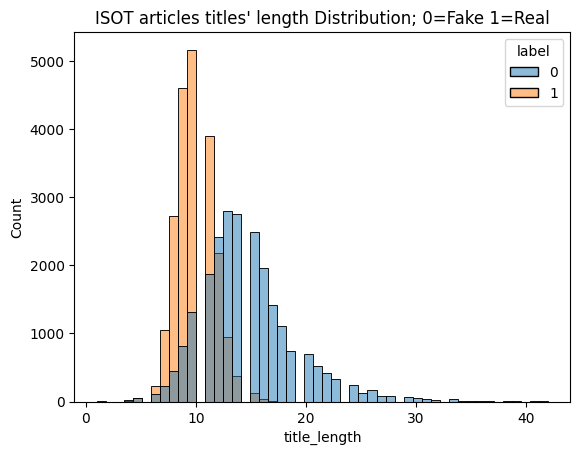

In [57]:
# Title length analysis

sns.histplot(data=df, x='title_length', hue='label', bins=50)
plt.title("ISOT articles titles' length Distribution; 0=Fake 1=Real")
plt.show()

### Generating words clouds for text content


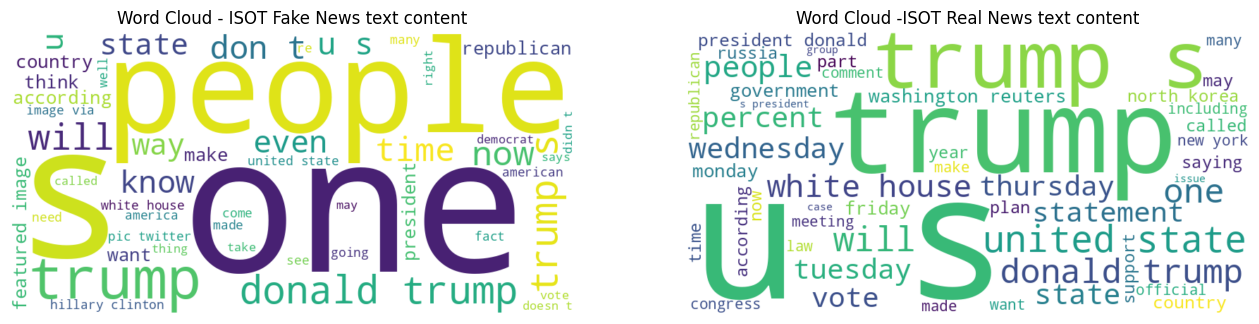

In [26]:
# Generating words clouds for text content

custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['said','say'])


# Combine all fake and real news texts into single big strings in lowercase :
df['text'] = df['text'].astype(str).str.lower()
fake_text = " ".join(df[df['label'] == 0]['text'])
real_text = " ".join(df[df['label'] == 1]['text'])

# Generate word clouds with stopwords removed
fake_wc = WordCloud(width=800, height=400, background_color='white',
                    stopwords=custom_stopwords, max_words=50).generate(fake_text)

real_wc = WordCloud(width=800, height=400, background_color='white',
                    stopwords=custom_stopwords, max_words=50).generate(real_text)

# Plot side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - ISOT Fake News text content')

plt.subplot(1, 2, 2)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud -ISOT Real News text content')

plt.show()

### Generating words clouds for titles

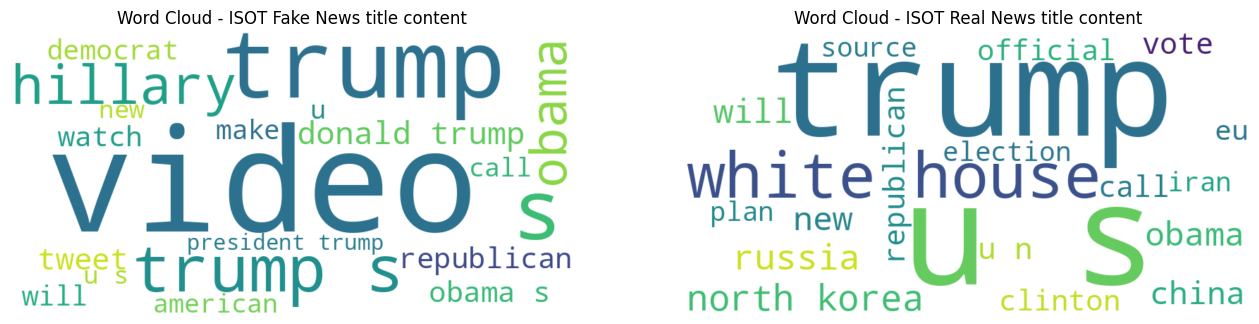

In [27]:
# Generating words clouds for titles

custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['said','say','says'])


# Combine all fake and real news texts into single big strings in lowercase :
df['title'] = df['title'].astype(str).str.lower()
fake_text = " ".join(df[df['label'] == 0]['title'])
real_text = " ".join(df[df['label'] == 1]['title'])

# Generate word clouds with stopwords removed
fake_wc = WordCloud(width=800, height=400, background_color='white',
                    stopwords=custom_stopwords, max_words=20).generate(fake_text)

real_wc = WordCloud(width=800, height=400, background_color='white',
                    stopwords=custom_stopwords, max_words=20).generate(real_text)

# Plot side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - ISOT Fake News title content')

plt.subplot(1, 2, 2)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - ISOT Real News title content')

plt.show()

## Pre-processing

In order to implement a **TF-IDF** based model, we will apply the following pre-processing steps:

- Convert all text to lower-case.
- Remove punctuation, URLs, Twitter handles, white spaces, and stop words.

In [28]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove Twitter handles
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()  #turns everything to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Drops stop words
    return text

df['clean_text'] = df['text'].apply(clean_text) #applies changes
df['clean_text']

[nltk_data] Downloading package stopwords to /Users/bianp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants tweeted great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new ye

## Train Test Split 

TF-IDF based model

In [29]:
X = df['clean_text']
y = df['label']

# Split data
X_train_raw, X_test_raw, y_train_TFIDF, y_test_TFIDF = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)

# Fit and transform training data, transform test data
X_train_TFIDF = tfidf_vectorizer.fit_transform(X_train_raw)
X_test_TFIDF = tfidf_vectorizer.transform(X_test_raw)


Logistic Regression

In [30]:
# Train and test :

clf = LogisticRegression(max_iter=1000, random_state=123)
clf.fit(X_train_TFIDF, y_train_TFIDF)

# Make predictions
y_pred = clf.predict(X_test_TFIDF)

# Evaluate performance
print("\nAccuracy test set:", accuracy_score(y_test_TFIDF, y_pred))
print("\nClassification Report test set:\n", classification_report(y_test_TFIDF, y_pred))
print("\nConfusion Matrix test set:\n", confusion_matrix(y_test_TFIDF, y_pred))



Accuracy test set: 0.9876391982182628

Classification Report test set:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4556
           1       0.99      0.99      0.99      4424

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix test set:
 [[4497   59]
 [  52 4372]]


In [31]:
# Cross validation based evaluation : 

# Transform the full dataset (no train/test split here)
X_TFIDF = tfidf_vectorizer.fit_transform(X)

# Initialize Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=123)

# Run 5-fold cross-validation and get accuracy scores
cv_scores = cross_val_score(clf, X_TFIDF, y, cv=5, scoring='accuracy')

print(f"Cross-validation accuracies: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")


Cross-validation accuracies: [0.98329621 0.98106904 0.97427617 0.9750529  0.98128968]
Mean accuracy: 0.9790
Standard deviation: 0.0036


## Pre-processing for Word2Vec

In order to implement a **Word2Vec** based model, we will apply the following pre-processing steps:

- Convert all text to lower-case.
- Remove punctuation, URLs, Twitter handles but leave white spaces, and stop words as it learns based on context 

In [32]:
def clean_text_w2v(text):
    """
    Preprocess text for Word2Vec:
    - Lowercase
    - Remove URLs, Twitter handles, punctuation
    - Keep white space and stop words
    """
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove Twitter handles (@username)
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation (keep white space)
    text = re.sub(r'[^\w\s]', '', text)
    # Optionally, strip extra white space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text_w2v'] = df['text'].apply(clean_text_w2v) #applies changes
#df['clean_text_w2v']

In [33]:
# === 1. Load and prepare data ===
X = df['clean_text_w2v']
y = df['label']

# Split data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Tokenize the text (split by space)
X_train_tokenized = [text.split() for text in X_train_raw]
X_test_tokenized = [text.split() for text in X_test_raw]

# === 2. Train Word2Vec model on training set only ===
w2v_model = Word2Vec(
    sentences=X_train_tokenized,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=123
)

from tqdm import tqdm

# === 3. Function to compute document vectors ===
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

# === 4. Convert training and test documents to vectors with tqdm ===
X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in tqdm(X_train_tokenized, desc='Processing train set')])
X_test_w2v = np.array([document_vector(doc, w2v_model) for doc in tqdm(X_test_tokenized, desc='Processing test set')])

# === 5. Train and test classifier ===
clf = LogisticRegression(max_iter=1000, random_state=123)
clf.fit(X_train_w2v, y_train)

# Make predictions
y_pred = clf.predict(X_test_w2v)

# === 6. Evaluate performance ===
print("\nWord2Vec on ISOT")
print("\nAccuracy test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report test set:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix test set:\n", confusion_matrix(y_test, y_pred))



Processing test set: 100%|██████████| 8980/8980 [05:16<00:00, 28.37it/s]



Word2Vec on ISOT

Accuracy test set: 0.9713808463251671

Classification Report test set:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4556
           1       0.97      0.97      0.97      4424

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980


Confusion Matrix test set:
 [[4428  128]
 [ 129 4295]]


Train Test Split Word2Vec model 

## KAGGLE FAKE OR REAL DATABASE

In [34]:
kaggle_df = pd.read_csv('/Users/bianp/Desktop/FakeNewsDetection/fake_or_real_news.csv')
kaggle_df.head()

Unnamed: 0  \
0        8476   
1       10294   
2        3608   
3       10142   
4         875   

                                                                                   title  \
0                                                           You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO)   
2                                            Kerry to go to Paris in gesture of sympathy   
3   Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!'   
4                                       The Battle of New York: Why This Primary Matters   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [35]:
# Check for missing data
print("\nMissing values:")
print(kaggle_df.isnull().sum())


Missing values:
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


In [36]:
kaggle_df['label'] = kaggle_df['label'].replace({'FAKE': 0, 'REAL': 1})

/var/folders/04/3mpn82554dnf94l0ttdmb70h0000gn/T/ipykernel_36768/3717111191.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  kaggle_df['label'] = kaggle_df['label'].replace({'FAKE': 0, 'REAL': 1})


In [37]:
# Check for balance proportion of fake vs real news 
print("\nClass distribution: ")
print(kaggle_df['label'].value_counts())


Class distribution: 
label
1    3171
0    3164
Name: count, dtype: int64


In [38]:
# Calculate mean length of article per label
kaggle_df['text_length'] = kaggle_df['text'].apply(lambda x: len(str(x).split()))
mean_lengths = kaggle_df.groupby('label')['text_length'].mean()
print("\nMean article length per label:")
print(mean_lengths)


Mean article length per label:
label
0    679.129267
1    873.257647
Name: text_length, dtype: float64


In [39]:
# Calculate mean length of article per label
kaggle_df['title_length'] = kaggle_df['title'].apply(lambda x: len(str(x).split()))
mean_lengths = kaggle_df.groupby('label')['title_length'].mean()
print("\nKaggle FoR Mean title length per label:")
print(mean_lengths)


Kaggle FoR Mean title length per label:
label
0    11.133059
1     9.861243
Name: title_length, dtype: float64


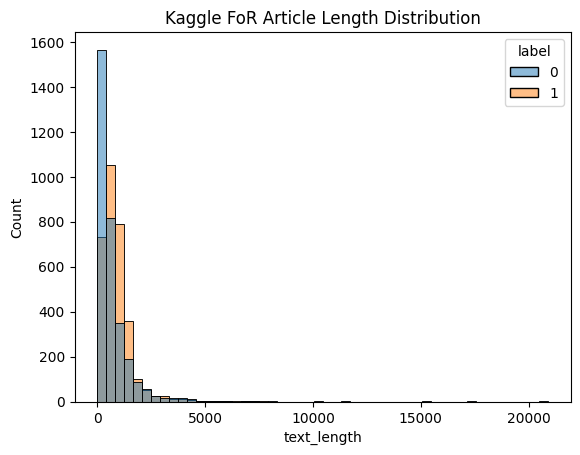

In [40]:
# Text length analysis

sns.histplot(data=kaggle_df, x='text_length', hue='label', bins=50)
plt.title('Kaggle FoR Article Length Distribution')
plt.show()

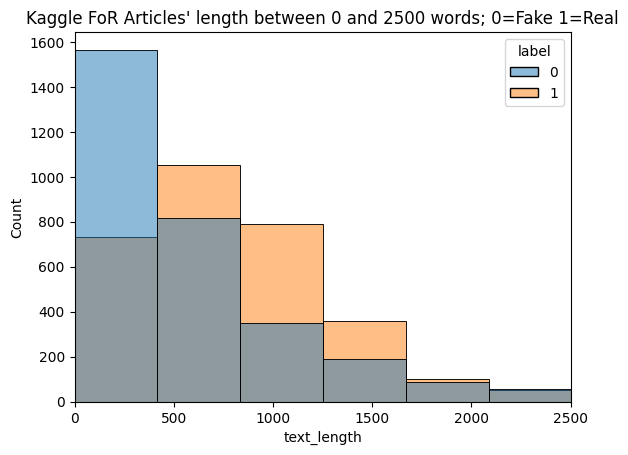

In [56]:
sns.histplot(data=kaggle_df, x='text_length', hue='label', bins=50)
plt.title("Kaggle FoR Articles' length between 0 and 2500 words; 0=Fake 1=Real")
plt.xlim(0, 2500)  # Set x-axis limits to 0–2500
plt.show()

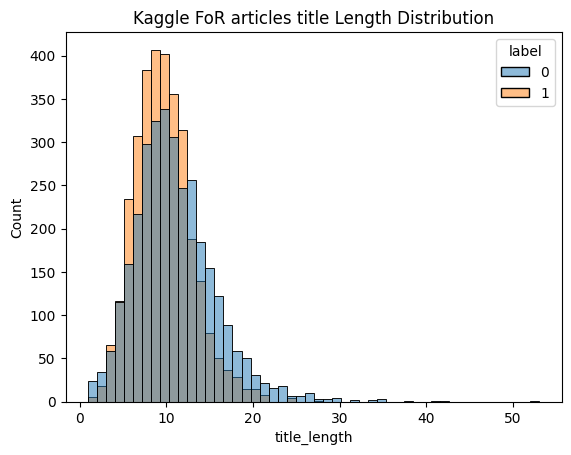

In [42]:
# Title length analysis

sns.histplot(data=kaggle_df, x='title_length', hue='label', bins=50)
plt.title('Kaggle FoR articles title Length Distribution')
plt.show()

### Generating words clouds for text content

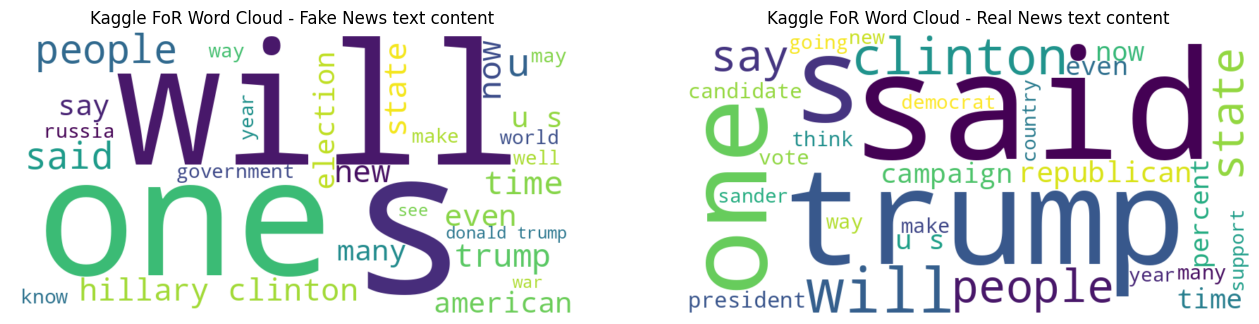

In [43]:
# Generating words clouds for text content

custom_stopwords = set(STOPWORDS)
#custom_stopwords.update(['said','say'])


# Combine all fake and real news texts into single big strings in lowercase :
kaggle_df['text'] = kaggle_df['text'].astype(str).str.lower()
kaggle_fake_text = " ".join(kaggle_df[kaggle_df['label'] == 0]['text'])
kaggle_real_text = " ".join(kaggle_df[kaggle_df['label'] == 1]['text'])

# Generate word clouds with stopwords removed
fake_wc = WordCloud(width=800, height=400, background_color='white',
                    stopwords=custom_stopwords, max_words=30).generate(kaggle_fake_text)

real_wc = WordCloud(width=800, height=400, background_color='white',
                    stopwords=custom_stopwords, max_words=30).generate(kaggle_real_text)


# Plot side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Kaggle FoR Word Cloud - Fake News text content')

plt.subplot(1, 2, 2)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Kaggle FoR Word Cloud - Real News text content')

plt.show()

### Generating words clouds for titles

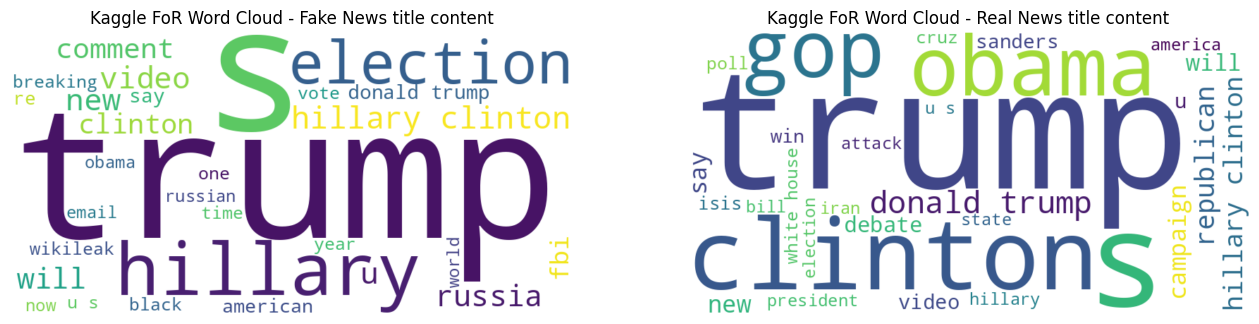

In [44]:
# Generating words clouds for titles

custom_stopwords = set(STOPWORDS)

# Combine all fake and real news texts into single big strings in lowercase :
kaggle_df['title'] = kaggle_df['title'].astype(str).str.lower()
kaggle_fake_text = " ".join(kaggle_df[kaggle_df['label'] == 0]['title'])
kaggle_real_text = " ".join(kaggle_df[kaggle_df['label'] == 1]['title'])

# Generate word clouds with stopwords removed
fake_wc = WordCloud(width=800, height=400, background_color='white',
                    stopwords=custom_stopwords, max_words=30).generate(kaggle_fake_text)

real_wc = WordCloud(width=800, height=400, background_color='white',
                    stopwords=custom_stopwords, max_words=30).generate(kaggle_real_text)


# Plot side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Kaggle FoR Word Cloud - Fake News title content')

plt.subplot(1, 2, 2)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Kaggle FoR Word Cloud - Real News title content')

plt.show()

## Pre-processing

In order to implement a **TF-IDF** based model, we will apply the following pre-processing steps:

- Convert all text to lower-case.
- Remove punctuation, URLs, Twitter handles, white spaces, and stop words.

In [45]:
# Applying clean_text() function as defined earlier : 

""" 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove Twitter handles
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()  #turns everything to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Drops stop words
    return text 
    """

kaggle_df['clean_text'] = kaggle_df['text'].apply(clean_text) #applies changes
kaggle_df['clean_text']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Train Test Split 

TF-IDF based model

In [46]:
X_kaggle = kaggle_df['clean_text']
y_kaggle = kaggle_df['label']

# Split data
X_train_raw_kaggle, X_test_raw_kaggle, y_train_TFIDF_kaggle, y_test_TFIDF_kaggle = train_test_split(X_kaggle, y_kaggle, test_size=0.2, random_state=123)

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)

# Fit and transform training data, transform test data
X_train_TFIDF_kaggle = tfidf_vectorizer.fit_transform(X_train_raw_kaggle)
X_test_TFIDF_kaggle = tfidf_vectorizer.transform(X_test_raw_kaggle)


Logistic Regression

In [47]:
# Train and test :

clf_kaggle = LogisticRegression(max_iter=1000, random_state=123)
clf_kaggle.fit(X_train_TFIDF_kaggle, y_train_TFIDF_kaggle)

# Make predictions
y_pred_kaggle = clf_kaggle.predict(X_test_TFIDF_kaggle)

# Evaluate performance
print("\nAccuracy test set:", accuracy_score(y_test_TFIDF_kaggle, y_pred_kaggle))
print("\nClassification Report test set:\n", classification_report(y_test_TFIDF_kaggle, y_pred_kaggle))
print("\nConfusion Matrix test set:\n", confusion_matrix(y_test_TFIDF_kaggle, y_pred_kaggle))



Accuracy test set: 0.9139700078926598

Classification Report test set:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       644
           1       0.95      0.87      0.91       623

    accuracy                           0.91      1267
   macro avg       0.92      0.91      0.91      1267
weighted avg       0.92      0.91      0.91      1267


Confusion Matrix test set:
 [[613  31]
 [ 78 545]]


In [48]:
# Cross validation based evaluation : 

# Transform the full dataset (no train/test split here)
X_TFIDF_kaggle = tfidf_vectorizer.fit_transform(X_kaggle)

# Initialize Logistic Regression
clf_kaggle = LogisticRegression(max_iter=1000, random_state=123)

# Run 5-fold cross-validation and get accuracy scores
cv_scores_kaggle = cross_val_score(clf_kaggle, X_TFIDF_kaggle, y_kaggle, cv=5, scoring='accuracy')

print(f"Cross-validation accuracies: {cv_scores_kaggle}")
print(f"Mean accuracy: {np.mean(cv_scores_kaggle):.4f}")
print(f"Standard deviation: {np.std(cv_scores_kaggle):.4f}")


Cross-validation accuracies: [0.91002368 0.90923441 0.92028414 0.91633781 0.91239148]
Mean accuracy: 0.9137
Standard deviation: 0.0041


## Pre-processing for Word2Vec

In order to implement a **Word2Vec** based model, we will apply the following pre-processing steps:

- Convert all text to lower-case.
- Remove punctuation, URLs, Twitter handles but leave white spaces, and stop words as it learns based on context 

In [49]:

kaggle_df['clean_text_w2v'] = kaggle_df['text'].apply(clean_text_w2v) #applies changes
#kaggle_df['clean_text_w2v']

In [50]:
# === 1. Load and prepare data ===
X = kaggle_df['clean_text_w2v']
y = kaggle_df['label']

# Split data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Tokenize the text (split by space)
X_train_tokenized = [text.split() for text in X_train_raw]
X_test_tokenized = [text.split() for text in X_test_raw]

# === 2. Train Word2Vec model on training set only ===
w2v_model = Word2Vec(
    sentences=X_train_tokenized,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=123
)

from tqdm import tqdm

# === 3. Function to compute document vectors ===
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

# === 4. Convert training and test documents to vectors with tqdm ===
X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in tqdm(X_train_tokenized, desc='Processing train set')])
X_test_w2v = np.array([document_vector(doc, w2v_model) for doc in tqdm(X_test_tokenized, desc='Processing test set')])

# === 5. Train and test classifier ===
clf = LogisticRegression(max_iter=1000, random_state=123)
clf.fit(X_train_w2v, y_train)

# Make predictions
y_pred = clf.predict(X_test_w2v)

# === 6. Evaluate performance ===
print("\nWord2Vec on Kaggle FoR")
print("\nAccuracy test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report test set:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix test set:\n", confusion_matrix(y_test, y_pred))



Processing test set: 100%|██████████| 1267/1267 [00:39<00:00, 32.31it/s]


Word2Vec on Kaggle FoR

Accuracy test set: 0.8831886345698501

Classification Report test set:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89       644
           1       0.89      0.87      0.88       623

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267


Confusion Matrix test set:
 [[574  70]
 [ 78 545]]


## Testing the generalisability of the model : TF IDT feautre

Use ISOT as train and Kaggle FoR for test

In [51]:
X = df['clean_text']
y = df['label']
X_kaggle = kaggle_df['clean_text']
y_kaggle = kaggle_df['label']


# Split data
X_TFIDF = tfidf_vectorizer.fit_transform(X)
X_TFIDF_kaggle = tfidf_vectorizer.transform(X_kaggle)
#y_TFIDF = tfidf_vectorizer.fit_transform(y)
#y_TFIDF_kaggle = tfidf_vectorizer.fit_transform(y_kaggle)



# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)


# Train and test :

clf = LogisticRegression(max_iter=1000, random_state=123)
clf.fit(X_TFIDF, y)

# Make predictions
y_pred_kaggle_g = clf.predict(X_TFIDF_kaggle)

# Evaluate performance
print("\nEvaluate the generasability of the model : Use ISOT as train and Kaggle FoR for test TF IDT feature")
print("\nAccuracy test set:", accuracy_score(y_kaggle, y_pred_kaggle_g))
print("\nClassification Report test set:\n", classification_report(y_kaggle, y_pred_kaggle_g))
print("\nConfusion Matrix test set:\n", confusion_matrix(y_kaggle, y_pred_kaggle_g))



Evaluate the generasability of the model : Use ISOT as train and Kaggle FoR for test TF IDT feature

Accuracy test set: 0.6405682715074981

Classification Report test set:
               precision    recall  f1-score   support

           0       0.59      0.91      0.72      3164
           1       0.80      0.37      0.51      3171

    accuracy                           0.64      6335
   macro avg       0.70      0.64      0.61      6335
weighted avg       0.70      0.64      0.61      6335


Confusion Matrix test set:
 [[2874  290]
 [1987 1184]]


Use Kaggle FoR as train and ISOT for test

In [52]:
X = df['clean_text']
y = df['label']
X_kaggle = kaggle_df['clean_text']
y_kaggle = kaggle_df['label']


# Split data
X_TFIDF_kaggle = tfidf_vectorizer.fit_transform(X_kaggle)
X_TFIDF = tfidf_vectorizer.transform(X)

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)


# Train and test :

clf = LogisticRegression(max_iter=1000, random_state=123)
clf.fit(X_TFIDF_kaggle, y_kaggle)

# Make predictions
y_pred_ISOT_g = clf.predict(X_TFIDF)

# Evaluate performance
print("\nEvaluate the generasability of the model : Use Kaggle FoR as train and ISOT for test TF IDT feature")
print("\nAccuracy test set:", accuracy_score(y, y_pred_ISOT_g))
print("\nClassification Report test set:\n", classification_report(y, y_pred_ISOT_g))
print("\nConfusion Matrix test set:\n", confusion_matrix(y, y_pred_ISOT_g))



Evaluate the generasability of the model : Use Kaggle FoR as train and ISOT for test TF IDT feature

Accuracy test set: 0.68876119203528

Classification Report test set:
               precision    recall  f1-score   support

           0       0.69      0.74      0.71     23481
           1       0.69      0.63      0.66     21417

    accuracy                           0.69     44898
   macro avg       0.69      0.69      0.69     44898
weighted avg       0.69      0.69      0.69     44898


Confusion Matrix test set:
 [[17451  6030]
 [ 7944 13473]]


## Testing the generalisability of the model : Word2Vec

Use Kaggle FoR as train and ISOT for test

In [53]:
X = df['clean_text_w2v']
y = df['label']
X_kaggle = kaggle_df['clean_text_w2v']
y_kaggle = kaggle_df['label']


# Tokenize the text (split by space)
X_train_tokenized = [text.split() for text in X_kaggle]
X_test_tokenized = [text.split() for text in X]

# === 2. Train Word2Vec model on training set only ===
w2v_model = Word2Vec(
    sentences=X_train_tokenized,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=123
)

from tqdm import tqdm

# === 3. Function to compute document vectors ===
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

# === 4. Convert training and test documents to vectors with tqdm ===
X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in tqdm(X_train_tokenized, desc='Processing train set')])
X_test_w2v = np.array([document_vector(doc, w2v_model) for doc in tqdm(X_test_tokenized, desc='Processing test set')])

# === 5. Train and test classifier ===
clf = LogisticRegression(max_iter=1000, random_state=123)
clf.fit(X_train_w2v, y_kaggle)

# Make predictions
y_pred = clf.predict(X_test_w2v)

# === 6. Evaluate performance ===
print("\nWord2Vec Use Kaggle FoR as train and ISOT for test :")
print("\nAccuracy test set:", accuracy_score(y, y_pred))
print("\nClassification Report test set:\n", classification_report(y, y_pred))
print("\nConfusion Matrix test set:\n", confusion_matrix(y, y_pred))



Processing test set: 100%|██████████| 44898/44898 [18:24<00:00, 40.67it/s] 



Word2Vec Use Kaggle FoR as train and ISOT for test :

Accuracy test set: 0.7499220455254132

Classification Report test set:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74     23481
           1       0.70      0.82      0.76     21417

    accuracy                           0.75     44898
   macro avg       0.76      0.75      0.75     44898
weighted avg       0.76      0.75      0.75     44898


Confusion Matrix test set:
 [[16011  7470]
 [ 3758 17659]]


Use ISOT as train and Kaggle FoR for test

In [54]:
X = df['clean_text_w2v']
y = df['label']
X_kaggle = kaggle_df['clean_text_w2v']
y_kaggle = kaggle_df['label']


# Tokenize the text (split by space)
X_train_tokenized = [text.split() for text in X]
X_test_tokenized = [text.split() for text in X_kaggle]

# === 2. Train Word2Vec model on training set only ===
w2v_model = Word2Vec(
    sentences=X_train_tokenized,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=123
)

from tqdm import tqdm

# === 3. Function to compute document vectors ===
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

# === 4. Convert training and test documents to vectors with tqdm ===
X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in tqdm(X_train_tokenized, desc='Processing train set')])
X_test_w2v = np.array([document_vector(doc, w2v_model) for doc in tqdm(X_test_tokenized, desc='Processing test set')])

# === 5. Train and test classifier ===
clf = LogisticRegression(max_iter=1000, random_state=123)
clf.fit(X_train_w2v, y)

# Make predictions
y_pred = clf.predict(X_test_w2v)

# === 6. Evaluate performance ===
print("\nWord2Vec Use ISOT as train and Kaggle FoR for test :")
print("\nAccuracy test set:", accuracy_score(y_kaggle, y_pred))
print("\nClassification Report test set:\n", classification_report(y_kaggle, y_pred))
print("\nConfusion Matrix test set:\n", confusion_matrix(y_kaggle, y_pred))



Processing test set: 100%|██████████| 6335/6335 [09:27<00:00, 11.17it/s]



Word2Vec Use ISOT as train and Kaggle FoR for test :

Accuracy test set: 0.6383583267561168

Classification Report test set:
               precision    recall  f1-score   support

           0       0.60      0.86      0.70      3164
           1       0.75      0.42      0.54      3171

    accuracy                           0.64      6335
   macro avg       0.67      0.64      0.62      6335
weighted avg       0.67      0.64      0.62      6335


Confusion Matrix test set:
 [[2718  446]
 [1845 1326]]
